### Importieren benötigter Bibliotheken

In [1]:
from __future__ import print_function, division
from sympy import symbols, simplify, trigsimp
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point, Particle
from sympy.physics.mechanics import inertia, RigidBody, KanesMethod
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)

# 1. Kinematik

### Koordinatensysteme / Bezugssysteme

In [2]:
# Initialisieren der benötigten Koordinatensysteme
inertial_frame = ReferenceFrame('I')
cart_frame = ReferenceFrame('A_frame')   
pendulum1_frame = ReferenceFrame('B')   #B statt P_1

### Orientierung und Zwangsbedingungen an den Koordinatensystemen

In [3]:
theta1 = dynamicsymbols('theta1')
x_dist = dynamicsymbols('q0')

In [4]:
# Zwangsbedingung des Bezugssystems P1 zum Inertialsystem:
###!! CART FRAME auf 0 setzen
#cart_frame.orient(inertial_frame, 'Axis', (x_dist, inertial_frame.x))
#cart_frame.set_ang_vel(inertial_frame, 0*inertial_frame.z)
#cart_frame.set_ang_vel(inertial_frame, 0*inertial_frame.y)
#cart_frame = inertial_frame.orientnew('A_frame', 'Axis', [x_dist, inertial_frame.x])
cart_frame.orient_space_fixed(inertial_frame, (0,0,0), '231')
#cart_frame = inertial_frame.orientnew('A_frame')
# setze fest, dass pendulum1 lediglich um die z-Achse rotieren kann
pendulum1_frame.orient(inertial_frame, 'Axis', (theta1, cart_frame.z))  # cart_frame.z
pendulum1_frame.dcm(cart_frame)

Matrix([
[ cos(theta1), sin(theta1), 0],
[-sin(theta1), cos(theta1), 0],
[           0,           0, 1]])

In [5]:
# Daraus ergibt sich dann, dass die die Position von pendulum1 mit der folgenden Rotationsmatrix berechnet werden kann:
# Returns the direction cosine matrix relative to the provided reference frame. (QUELLE: https://docs.sympy.org/latest/modules/physics/vector/api/classes.html)
pendulum1_frame.dcm(inertial_frame)

Matrix([
[ cos(theta1), sin(theta1), 0],
[-sin(theta1), cos(theta1), 0],
[           0,           0, 1]])

<p> Multipliziert man diese Rotationsmatrix mit einem Vektor, lässt sich damit der Vektor um die entsprechenden Winkel zum Inertialsystem drehen</p>

### Massepunkte und Gelenkpunkte

In [6]:
# Distanz zw. Ursprungspunkt und Wagenpunkt/Ankerpunkt
origin = Point('O')
origin.set_vel(inertial_frame, 0) # origin statisch setzen

# Zunächst setzen wir einen fixen Ankerpunkt im Inertialsystem
ankle = Point('A')

ankle.set_pos(origin, x_dist * inertial_frame.x)
#ankle.set_vel(cart_frame, 0) # Ankerpunkt in Cart-System statisch setzen

In [7]:
# Endpunkt des pendulum1 
p1 = Point('P_1')

# definieren nun eine Länge für unser erstes Pendel
pendulum1_length = symbols('l_1')

In [8]:
# Die Position des Punktes P lässt sich jetzt über die Länge l1 * der Richtung y des Bezugssystems P beschreiben
p1.set_pos(ankle, pendulum1_length * pendulum1_frame.y)

# Durch die Multiplikation mit der Rotationsmatrix zwischen dem Inertialsystems und Pendulum1 kann der Punkt P
# im Bezug zum Inertialsystem beschrieben werden
#?? ist das Inertialsystem noch korrekt?
p1.pos_from(ankle).express(inertial_frame).simplify()

- l_1*sin(theta1)*I.x + l_1*cos(theta1)*I.y

<p>Da wir nicht mit masselosen Pendeln rechnen wollen, müssen wir außerdem die Massenschwerpunkte unserer Pendel angeben</p>

In [9]:
# wir machen dies analog zur Vorgehensweise der Gelenkpunkte
pendulum1_mass_length = symbols('l_m1')
pendulum1_mass_center = Point('P_m1')
pendulum1_mass_center.set_pos(ankle, pendulum1_mass_length * pendulum1_frame.y)

### Aufstellen der Differentialgleichungen

In [10]:
#?? Hier Geschwindigkeiten hinzufügen bzgl des Wagens
cart_vel = dynamicsymbols('v_cart')
kinematical_differential_equations = [cart_vel - x_dist.diff()] #translat. Geschwindigkeit

In [11]:
# Wir benötigen die Winkelgeschwindigkeiten
omega1 = dynamicsymbols('omega1')

# Diese sind genauso groß, wie die Ableitung des Winkels Theta1 nach der Zeit --> 𝜔 = 𝜃˙
# Diese Formulierung müssen wir tätigen, da wir unsere Bewegungsgleichung nach Kanes-Methode aufstellen.
# Zudem benötigen alle numerischen Integratoren eine DGL 1.Ordnung
#kinematical_differential_equations = [omega1 - theta1.diff()]
#?? WARUM GENAUSO GROß???

#rotat. Geschwindigkeit:
kinematical_differential_equations.append(omega1 - theta1.diff())

#tranlat. Geschindigkeit: 
#kinematical_differential_equations.append((cart_vel + x_dist.diff())*inertial_frame.x - theta1.diff()*pendulum1_mass_length*pendulum1_frame.y)

kinematical_differential_equations

[v_cart - q0', omega1 - theta1']

In [12]:
# Der Ankerpunkt wird mit Wagengeschwindigkeit angenommen
ankle.set_vel(inertial_frame, cart_vel*inertial_frame.x)

In [13]:
# Die erste Winkelgeschwindigkeit rotiert um die Z-Achse 
pendulum1_frame.set_ang_vel(cart_frame, omega1*cart_frame.z)

#Returns the angular velocity Vector of the ReferenceFrame. Quelle: https://docs.sympy.org/latest/modules/physics/vector/api/classes.html
pendulum1_frame.ang_vel_in(inertial_frame)

theta1'*I.z

# 2. Massenträgheiten

### Massenträgheiten

In [14]:
pendulum1_mass = symbols('m_1')

In [15]:
pendulum1_inertia = symbols('I_p1')

In [16]:
help(inertia)

Help on function inertia in module sympy.physics.mechanics.functions:

inertia(frame, ixx, iyy, izz, ixy=0, iyz=0, izx=0)
    Simple way to create inertia Dyadic object.
    
    Explanation
    
    If you don't know what a Dyadic is, just treat this like the inertia
    tensor. Then, do the easy thing and define it in a body-fixed frame.
    
    Parameters
    
    frame : ReferenceFrame
        The frame the inertia is defined in
    ixx : Sympifyable
        the xx element in the inertia dyadic
    iyy : Sympifyable
        the yy element in the inertia dyadic
    izz : Sympifyable
        the zz element in the inertia dyadic
    ixy : Sympifyable
        the xy element in the inertia dyadic
    iyz : Sympifyable
        the yz element in the inertia dyadic
    izx : Sympifyable
        the zx element in the inertia dyadic
    
    Examples
    
    >>> from sympy.physics.mechanics import ReferenceFrame, inertia
    >>> N = ReferenceFrame('N')
    >>> inertia(N, 1, 2, 3)
    (N.x|

In [17]:
# Das Dyadsiche Produkt ermöglicht uns das speichern der Trägheit als Tensor in Abhängigkeit zum Bezugssystem
pendulum1_inertia_dyadic = inertia(pendulum1_frame, 0, 0, pendulum1_inertia)
pendulum1_inertia_dyadic

I_p1*(B.z|B.z)

In [18]:
pendulum1_inertia_dyadic.to_matrix(pendulum1_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_p1]])

In [19]:
pendulum1_central_inertia = (pendulum1_inertia_dyadic, pendulum1_mass_center)

In [20]:
#A gleich Masseschwerpunkt Wagen
cart_mass = symbols('m_cart')
cart = Particle('Cart', ankle, cart_mass)  #Particle 1

In [21]:
# Eine komplette Beschreibung des Rigid Bodys besteht aus: Massenschwerpunkt, Bezugssystem, Masse und Trägheit
pendulum1 = RigidBody('Pendulum 1', pendulum1_mass_center, pendulum1_frame,
                      pendulum1_mass, pendulum1_central_inertia)

# 3. Kinetik (extern aufgeprägte Kräfte)

In [22]:
g = symbols('g')

In [23]:
pendulum1_grav_force_vector = -pendulum1_mass * g * inertial_frame.y
pendulum1_grav_force_vector

- g*m_1*I.y

In [24]:
# Die Gravitationskraft legen wir immer mit -y Richtung unseres Inertialsystems an
pendulum1_grav_force = (pendulum1_mass_center, pendulum1_grav_force_vector)

In [25]:
#??
cart_grav_force_vector = -cart_mass * g * inertial_frame.y
cart_grav_force_vector

- g*m_cart*I.y

In [26]:
cart_grav_force = (ankle, cart_grav_force_vector)

In [27]:
# Zusätzlich könnten wir an unserem Rotations-FHG der Gelenke auch ein Moment aufprägen
ankle_torque, p1_torque = dynamicsymbols('T_a, T_p1')
pendulum1_torque_vector = ankle_torque * cart_frame.z - p1_torque * cart_frame.z
pendulum1_torque = (pendulum1_frame, pendulum1_torque_vector)
pendulum1_torque_vector

(T_a - T_p1)*A_frame.z

# 4. Aufstellen der Bewegungsgleichungen

In [28]:
positions = [x_dist, theta1]
#angles = [theta1]

#speeds = [omega1]
speeds = [cart_vel, omega1]
# Wir hatten dies bereits im Kapitel 1 - Kinematik definiert
kinematical_differential_equations

[v_cart - q0', omega1 - theta1']

In [29]:
# Zusammentragen aller von außen aufgeprägten Kräfte
loads = [cart_grav_force,
         pendulum1_grav_force,
         pendulum1_torque]
loads

[(A, - g*m_cart*I.y), (P_m1, - g*m_1*I.y), (B, (T_a(t) - T_p1(t))*A_frame.z)]

In [30]:
# Wir erinnern uns an die angelegten Starrkörper
bodies = [cart, 
          pendulum1]
bodies

[Cart, Pendulum 1]

<p>Die Formulierung der Bewegungsgleichungen nach Kane sieht der bekannten Form nach Newton Euler sehr ähnlich:</p>
<p>Kanes Formulierung: $F_r + F_r^* = 0$</p>
<p>Newton Euler Formulierung: ${F} = {m}{a} \hspace{1cm} {T} = {I}{\alpha}$</p>

In [31]:
#kane = KanesMethod(inertial_frame, angles, speeds, kinematical_differential_equations)
kane = KanesMethod(inertial_frame, positions, speeds, kinematical_differential_equations)

In [32]:
fr, frstar = kane.kanes_equations(bodies, loads)

In [33]:
fr

Matrix([
[                                  0],
[g*l_m1*m_1*sin(theta1) + T_a - T_p1]])

In [34]:
frstar

Matrix([
[-l_m1*m_1*omega1**2*sin(theta1) + l_m1*m_1*cos(theta1)*omega1' - (m_1 + m_cart)*v_cart'],
[                            l_m1*m_1*cos(theta1)*v_cart' - (I_p1 + l_m1**2*m_1)*omega1']])

In [35]:
trigsimp(fr + frstar)

Matrix([
[          -l_m1*m_1*omega1**2*sin(theta1) + l_m1*m_1*cos(theta1)*omega1' - (m_1 + m_cart)*v_cart'],
[g*l_m1*m_1*sin(theta1) + l_m1*m_1*cos(theta1)*v_cart' - (I_p1 + l_m1**2*m_1)*omega1' + T_a - T_p1]])

In [36]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1, 0,                     0,                     0],
[0, 1,                     0,                     0],
[0, 0,          m_1 + m_cart, -l_m1*m_1*cos(theta1)],
[0, 0, -l_m1*m_1*cos(theta1),    I_p1 + l_m1**2*m_1]])

In [37]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                             v_cart],
[                             omega1],
[    -l_m1*m_1*omega1**2*sin(theta1)],
[g*l_m1*m_1*sin(theta1) + T_a - T_p1]])

### Damit haben wir alle Dinge beisammen:
<p>- Bezugssysteme</p>
<p>- Gelenkpunkte + Zwangsbedingungen</p>
<p>- Massepunkte</p>
<p>- Massenträgheit</p>
<p>- Kinetik (externe Kräfte)</p>
<p>- Formulierung der Bewegungsgleichungen</p>
<p>- Umformen für die Simulation in Massenabhängikeitsmatrix und Kraftabhängigkeitsmatrix als DGL 1.Ordnung $M(x,t)\dot x = f(x,t)$ (x=statevector)</p>

# 5. Lösen der Bewegungsgleichung

In [38]:
from numpy import deg2rad, rad2deg, array, zeros, linspace
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
from sympy.physics.vector import init_vprinting, vlatex
%matplotlib inline
rcParams['figure.figsize'] = (14.0, 6.0)

C:\Users\lenna\anaconda3\lib\site-packages\sympy\printing\ccode.py:8: SymPyDeprecationWarning: 

importing from sympy.printing.ccode has been deprecated since SymPy
1.7. Use Import from sympy.printing.c instead. See
https://github.com/sympy/sympy/issues/20256 for more info.

  SymPyDeprecationWarning(


In [39]:
constants = [cart_mass,
             pendulum1_length,
             pendulum1_mass_length,
             pendulum1_mass,
             pendulum1_inertia,
             g]
constants

[m_cart, l_1, l_m1, m_1, I_p1, g]

In [40]:
specified = [ankle_torque, p1_torque]

In [41]:
# wir lassen uns die Gleichung nach x' umstellen
#https://pydy.readthedocs.io/en/v0.3.1/system.html
right_hand_side = generate_ode_function(forcing_vector, positions, #angles,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [42]:
right_hand_side


<function pydy.codegen.ode_function_generators.ODEFunctionGenerator._create_rhs_function.<locals>.rhs(*args)>

In [43]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(4,)
        The state vector is ordered as such:
            - q0(t)
            - theta1(t)
            - v_cart(t)
            - omega1(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(2,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 2. If the value is a
        function it must be of the form g(x, t), wher

In [44]:
import numpy as np
# Festlegen der Initialbedingungen für die numerische Lösung der DGL

# Zu Beginn setzen wir beide Geschwindigkeiten auf 0
# und die beiden Winkel versetzen wir nach belieben
#x0 = zeros(2)
x0 = zeros(4)
x0[1] = deg2rad(10)
x0[2] = 0.1
#x0[0] = deg2rad(120)
#x0[1] = deg2rad(120)

x0

array([0.        , 0.17453293, 0.1       , 0.        ])

In [45]:
# Wir setzen nun realistische Werte für unsere Konstanten an
numerical_constants = array([2.0,  #cart_mass [kg]
                             0.8,  # pendulum1_length [m]
                             0.4,  # pendulum1_com_length [m]
                             4.0,  # pendulum1_mass [kg]
                             1.0,  # pendulum1_inertia [kg*m^2]
                             9.81],  # acceleration due to gravity [m/s^2]
                            )

In [46]:
# Wir setzen auch die Gelenkmomente initial auf 0
numerical_specified = array([0, 0])

<p>Mit den bekannten Anfangsbedingungen wollen wir über unseren gewünschten Beobachtungszeitraum numerisch integrieren.</p>
<p>Dazu geben wir dem Solver (z. B. Runge-Kutta) unsere Anfangsbedingungen, die Gleichung für x' und den Zeitraum sowie die Schrittweite t.</p>

In [47]:
frames_per_sec = 30
final_time = 20
t = linspace(0, final_time, final_time * frames_per_sec)

In [48]:
#scipy.integrate.odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0, tfirst=False)
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
#Solves the initial value problem for stiff or non-stiff systems of first order ode-s
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

In [49]:
y.shape

(600, 4)

# 6. Visualisierung

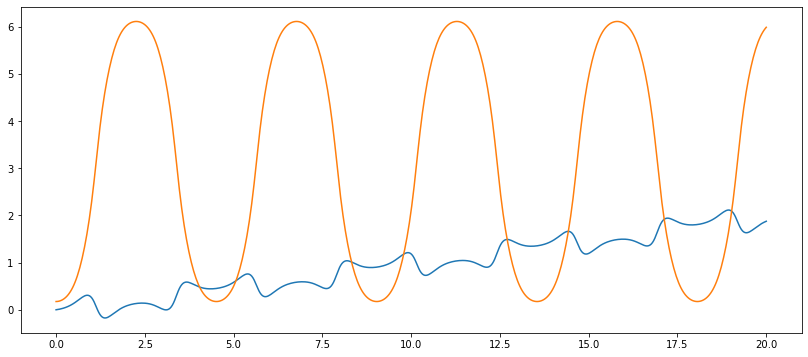

In [50]:
plot(t, y[:,0], t, y[:,1])  #Distanz zw. O und A; q0

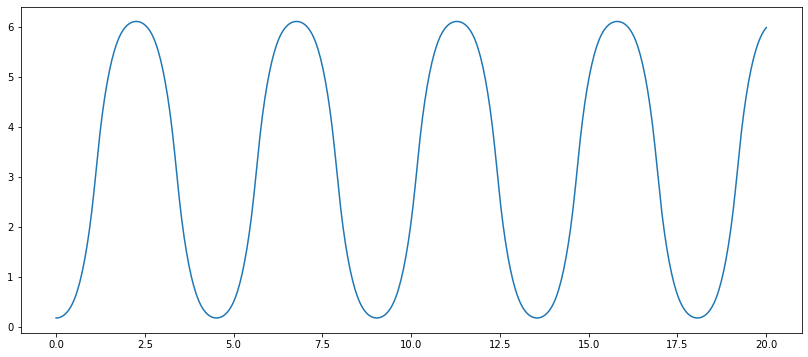

In [51]:
plot(t, y[:,1])  #theta1

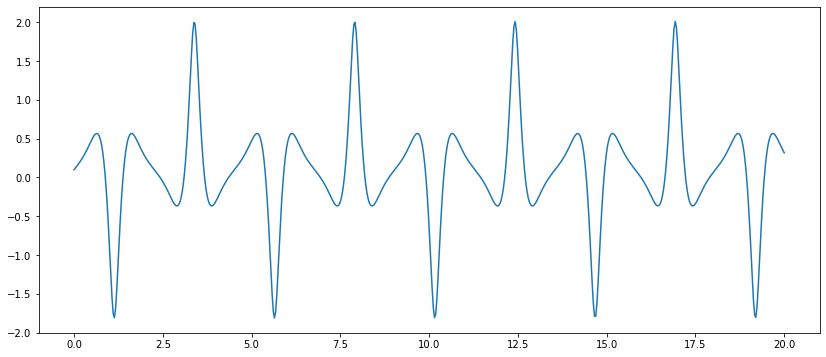

In [52]:
plot(t, y[:,2]) 

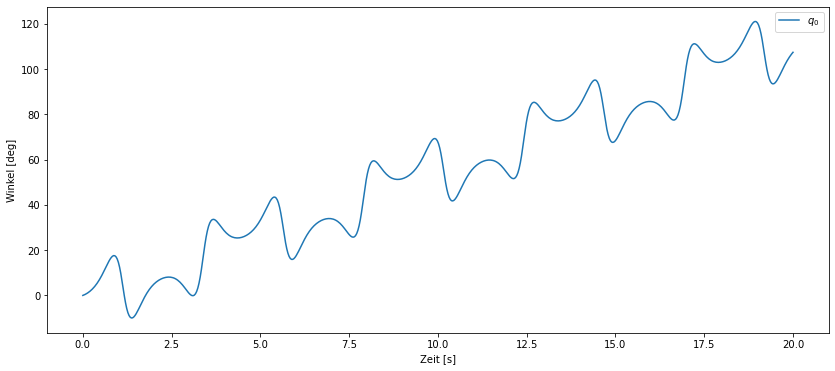

In [53]:
# Darstellung der zwei Winkel über die Simulationsdauer
plot(t, rad2deg(y[:, :1]))
xlabel('Zeit [s]')
ylabel('Winkel [deg]')
legend(["${}$".format(vlatex(c)) for c in positions])

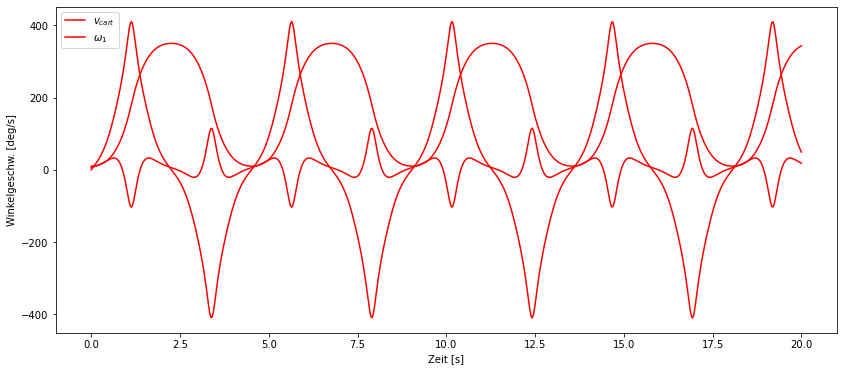

In [54]:
# Darstellung der beiden Geschwindigkeiten über die Simulationsdauer
plot(t, rad2deg(y[:, 1:]), color='r') # siehe y.shape
xlabel('Zeit [s]')
ylabel('Winkelgeschw. [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])

In [56]:
from pydy.viz.shapes import Cylinder, Sphere, Cube
import pydy.viz
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz.scene import Scene

# Für die Punkte legen wir schwarze Kugeln an
ankle_shape = Sphere(color='black', radius=0.1)
p1_shape = Sphere(color='black', radius=0.1)
#
origin_shape = Sphere(color='yellow', radius=0.1) 


# setzen die erzeugten Geometrien an die Punkte
origin_vis_frame = VisualizationFrame(inertial_frame, origin, origin_shape)
ankle_viz_frame = VisualizationFrame(inertial_frame, ankle, ankle_shape)
p1_viz_frame = VisualizationFrame(inertial_frame, p1, p1_shape)

# umformen der Konstanten in für das Programm leserliches Format
constants_dict = dict(zip(constants, numerical_constants))

# Setzen der Geometrie für die Starrkörper
cart_shape = Cube(length=0.3, color='green')
cart_vis_frame = VisualizationFrame('Cart', cart_frame, ankle, cart_shape)

pendulum1_center = Point('p1_c')
pendulum1_center.set_pos(ankle, pendulum1_length / 2 * pendulum1_frame.y)

pendulum1_shape = Cylinder(radius=0.08, length=constants_dict[pendulum1_length], color='blue')
pendulum1_viz_frame = VisualizationFrame('Pendulum 1', pendulum1_frame, pendulum1_center, pendulum1_shape)

# Erstellen der Szene mit dem Inertialsystem/Ankerpunkt in der Mitte
scene = Scene(inertial_frame, origin)

# Laden der Starrkörper in die Szene
scene.visualization_frames = [ankle_viz_frame,
                              p1_viz_frame,
                              cart_vis_frame,
                              pendulum1_viz_frame,
                              origin_vis_frame
                             ]

# Darstellung und einfügen der Ergebnisse
scene.states_symbols = positions + speeds
scene.constants = constants_dict
scene.states_trajectories = y

# öffnen der Simulation
scene.display()

C:\Users\lenna\Desktop\Lennart\Uni\SDS\InvertedPendulum\MKS\pydy-resources\pydy-resources
Serving HTTP on 127.0.0.1 port 8001 ...
To view visualization, open:

http://localhost:8001/index.html?load=2022-01-25_10-42-39_scene_desc.json
Press Ctrl+C to stop server...


127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /index.html?load=2022-01-25_10-42-39_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /css/slider.css HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /css/codemirror/codemirror.css HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /css/codemirror/blackboard.css HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /js/external/jquery/jquery.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /js/external/jquery/jquery-ui.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /js/external/bootstrap/bootstrap.min.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /js/external/codemirror/codemirror.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 10:42:42] "GET /js/external/codemirror/javascript-mode.js HTTP/1.1" 200 -
127.0.